In [1]:
#import all libraries here
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import os
import glob


# <span style= "color:orange; font-family:monteserrat ;" >Data processing</span>

In [4]:
# df = pd.read_csv("fvc_data/approx-flow-volume-data/clothMask/005_FVC_Cloth_1.json.csv")


# vol = df["Volume"]
# flow = df["Flow"]
# plt.plot(vol,flow)

# print(len(vol))
# vol = vol.to_numpy()[::500]
# flow = flow.to_numpy()[::500]
# plt.plot(vol,flow)
def resample_uninformly(file,num_samples):
    df = pd.read_csv(file,usecols = [0,1],names=["Volume","Flow"])
    vol = df["Volume"].to_numpy()
    flow = df["Flow"].to_numpy()

    maxx_vol = vol[-1]
    x_to_interp = np.arange(0,maxx_vol,(maxx_vol/num_samples)) 

    y_interp = np.interp(x_to_interp,vol,flow)
    return x_to_interp,y_interp


# # plt.plot(vol,flow)
# plt.rcParams["figure.figsize"] = (5,3)

# file = "fvc_data/ground_truth_flow_volume/sumit.csv"
# num_samples = 32000

# x_n,y_n = resample_uninformly(file,num_samples)
# print(len(x_n))
# plt.plot(x_n,y_n)


def create_interpolated_gt_dataset(folder,num_samples,output_folder="./"):
    types = (folder + os.sep + '*.csv',)  # the tuple of file types
    files_list = []

    for files in types:
        files_list.extend(glob.glob(files))
    
    for file in files_list:
        print(file)
        x,y = resample_uninformly(file,num_samples)
        df_tmp = pd.DataFrame({"Volume":x,"Flow":y})
        df_tmp.to_csv(output_folder+"/"+file.split("/")[-1])

# create_interpolated_gt_dataset("fvc_data/ground_truth_flow_volume/",32000,"fvc_data/ground_truth_interpolated/")

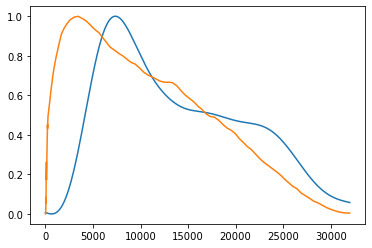

In [14]:
# df = pd.read_csv("fvc_data/approx-flow-volume-data/clothMask/005_FVC_Cloth_1.json.csv")
df = pd.read_csv("training_files/X/1.csv")


vol = df["Volume"]
flow = df["Flow"]
plt.plot((flow-min(flow))/(max(flow)-min(flow)))

df = pd.read_csv("training_files/y/1.csv")


vol = df["Volume"]
flow = df["Flow"]
plt.plot((flow-min(flow))/(max(flow)-min(flow)))



In [11]:
def get_windowed_samples(file1,file2,window_size):
    
    lst1 = pd.read_csv(file1)['Flow'].to_numpy()
    lst2 = pd.read_csv(file2)['Flow'].to_numpy()
    lst1 = (lst1-min(lst1))/(max(lst1)-min(lst1))
    lst2 = (lst2-min(lst2))/(max(lst2)-min(lst2))

    
    min_len = min(len(lst1),len(lst2))
    lst_final1 = []
    lst_final2 = []
    for i in range(min_len-window_size):
        lst_final1.append(lst1[i:i+window_size])
        lst_final2.append(lst2[i:i+window_size])

    lst_final1 = np.array(lst_final1)
    lst_final2 = np.array(lst_final2)
    return lst_final1,lst_final2
    
    
def create_main_dataset():
#     files_list = [12,13,14]
#     files_list = [0,1,3,4,8,9,10]
    files_list = [0]

    output_arr_X = None
    output_arr_y = None
    
    for file in files_list:
        arr_temp1,arr_temp2 = get_windowed_samples("training_files/X/{0}.csv".format(file),"training_files/y/{0}.csv".format(file),599)
        if output_arr_X is None:
            output_arr_X = arr_temp1
            output_arr_y = arr_temp2
        else:
            output_arr_X = np.concatenate([output_arr_X,arr_temp1],axis=0)
            output_arr_y = np.concatenate([output_arr_y,arr_temp2],axis=0)
    return output_arr_X,output_arr_y
    
# a,b = get_windowed_samples("training_files/X/0.csv","training_files/y/0.csv",599)
# print(a.shape)
# X,y = create_main_dataset()
# print(X.shape)
# print(y.shape)
# np.save("X_train",X)
# np.save("y_train",y)


(31401, 599)


In [2]:
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

In [15]:
print(X_train.shape)

X_train = X_train.reshape(len(X_train),599,1)
y_train  = y_train.reshape(len(y_train),599,1)
print(X_train.shape)
# print(y_train.shape)

X_test = X_test.reshape(len(X_test),599,1)
y_test = y_test.reshape(len(y_test),599,1)




(219807, 599)
(219807, 599, 1)


## <span style="color:red" > MODEL </span>

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten


model = Sequential()

model.add(Conv1D(filters=30, kernel_size=10, activation='relu', strides=1,input_shape=(599,1)))
model.add(Conv1D(filters=30, kernel_size=8, activation='relu'))
model.add(Conv1D(filters=40, kernel_size=6, activation='relu'))
model.add(Conv1D(filters=50, kernel_size=5, activation='relu'))
model.add(Conv1D(filters=50, kernel_size=5, activation='relu'))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(599, activation='relu'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["mse"])

model.fit(X_train,y_train,epochs = 10,batch_size = 32,verbose=1)



In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 590, 30)           330       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 583, 30)           7230      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 578, 40)           7240      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 574, 50)           10050     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 570, 50)           12550     
_________________________________________________________________
flatten (Flatten)            (None, 28500)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2